# Exploratory analysis of meteorological data

## Data available at http://sonda.ccst.inpe.br/infos/index.html

### Importing necessary libraries

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

Edit the list below, with each location's acronym

In [2]:
locations = ['BRB', 'CPA', 'PTR', 'SMS']

### Creating main Dataframe from individual monthly Dataframes

In case of "<font color='red'>ParserError:</font> Error tokenizing data. C error: Expected 17 fields in line xxx, saw 18"
Open the file in question with MS Excel, delete the first blank column after the end of the data, save and rerun the cell below


In [3]:
# Creating empty list to store Dataframes, this will be the final Dataframe
main_df = []

# Looping through all locations
for location in locations:
    
    # Setting file path, each folder must have the same name as the location in list "locations"
    path = rf"C:\Users\rodri\Documents\Unifesp\Mestrado\Dados cidades\{location}"
    directory = os.fsencode(path)
    os.chdir(path)

    # Creating empty list to store Dataframes of each location
    location_df = []

    # Looping through files in the folder
    for file in os.listdir(directory):
        df = pd.read_csv(file.decode('utf-8'), header=None, sep=';', low_memory=False)

        # Some files have different column lenght (no datetime),
        # the following "if" ensures the columns of interest are properly named
        if len(df.columns) == 17:
            df.rename(columns={5: 'global_rad', 11: 'temp', 14: 'prec'}, inplace=True)
        else:
            df.rename(columns={4: 'global_rad', 10: 'temp', 13: 'prec'}, inplace=True)

        # Extracting the corresponding date from the file name
        file_year = str(2000 + int(file.decode('utf-8')[3:5]))
        file_month = file.decode('utf-8')[5:7]
        file_days = str(int(len(df)/24/60))

        # Setting start/end date
        start_date = f'{file_year}-{file_month}-01 00:00:00'
        end_date = f'{file_year}-{file_month}-{file_days} 23:59:00'

        # Creating a datetime range and setting it as Dataframe index
        # Some files already have a datetime column, but this will ensure we dont have to worry about it if it doesn't
        df.index = pd.date_range(start = start_date, end = end_date, freq = 'min')

        # Appending Dataframe columns of interest to list
        # Resampling the data by the hour, calculating the temperature and global radiation means, total precipitation
        location_df.append(df[['global_rad', 'temp', 'prec']].resample('H').agg({'global_rad': np.mean, 'temp': np.mean, 
                                                                                    'prec': np.sum}))

    # Turning list into a single Dataframe of current location
    location_df = pd.concat(location_df)
    location_df['city'] = file.decode('utf-8')[0:3]
    
    # Appending to the final Dataframe
    main_df.append(location_df)

# Merging all Dataframes into a single and final Dataframe
main_df = pd.concat(main_df)

### Checking data integrity (outliers and missing values)

In [4]:
main_df.city.unique()

array(['BRB', 'CPA', 'PTR', 'SMS'], dtype=object)

#### Brasília (BRB)

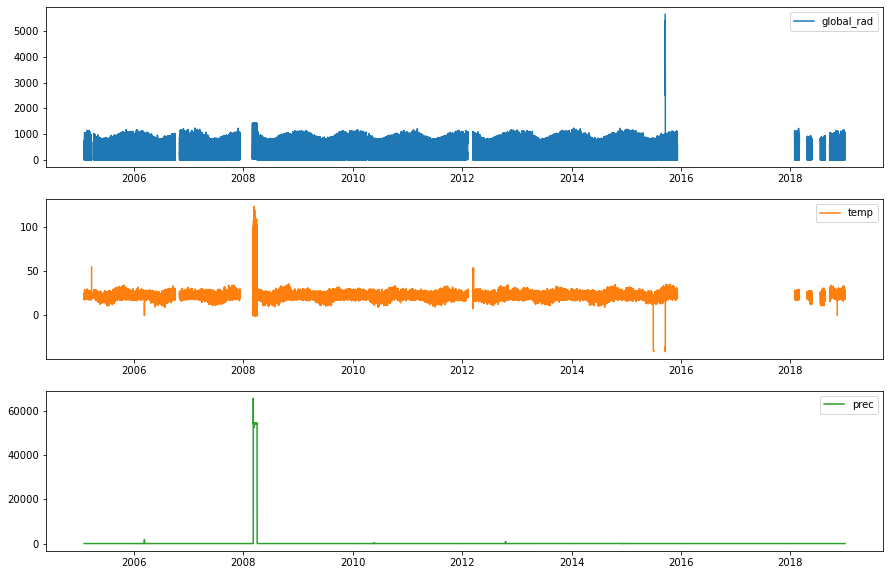

In [5]:
main_df[main_df.city == 'BRB'].plot(subplots= True, figsize=(15, 10), sharex= False, sharey=False)
plt.show()

It appears we have some gaps and outliers in both global radiation and temperature data, the precipitation data is completely compromised, therefore we must seek another weather station to be used as data source for this variable.

##### Global radiation

First, let us deal with our outliers and gaps:

In [6]:
df_brb = main_df[main_df.city == 'BRB'].drop(columns=['city'])

The solar constant value is 1327 w/m², so any number above it is most likely an error, first, let us find how many of those we have in our Dataframe.

In [7]:
df_brb.global_rad[df_brb.global_rad > 1327]

2008-03-01 22:00:00    1349.500000
2008-03-01 23:00:00    1409.500000
2008-03-02 22:00:00    1349.500000
2008-03-02 23:00:00    1409.500000
2008-03-03 22:00:00    1349.500000
                          ...     
2015-09-17 23:00:00    4187.650000
2015-09-18 00:00:00    5273.510204
2015-09-18 11:00:00    5174.720000
2015-09-18 12:00:00    4146.950000
2015-09-18 13:00:00    1675.266667
Name: global_rad, Length: 86, dtype: float64

16 values, in order to correct those numbers we can calculate the mean value of the global radiation for that same hour/day and replace it with the result. But first, we have to determine when exactly such values take place, so we can exclude this period from our calculations, otherwise they will affect the mean value.

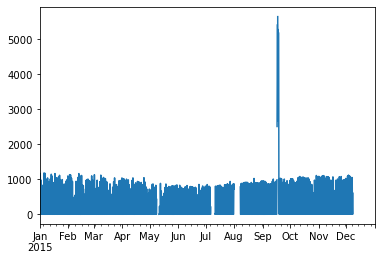

In [8]:
mask = df_brb.index.year == 2015, 'global_rad'
df_brb.loc[mask].plot()
plt.show()

Our first period takes place during September 2015.

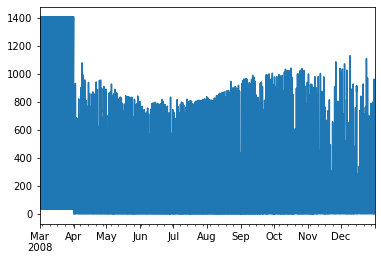

In [9]:
df_brb.loc[df_brb.index.year == 2008, 'global_rad'].plot()
plt.show()

And our second period takes place during March 2008.

In [10]:
# Getting every index where the global radiation values exceed the solar constant
outlier_index = df_brb.global_rad[df_brb.global_rad > 1327].index

In [11]:
# First set of masks, to include the period of 03/2008 which is not included in our outlier interval
mask1 = df_brb.index.month.isin([3])
mask2 = df_brb.index.year.isin([2008])

# Second set of masks, to include the period of where values are over the solar constant
mask3 = df_brb.index.isin(outlier_index)

In [12]:
# Creating final mask with the period where we know the outliers won't affect the final means
mask = ~(mask1 & mask2) & ~(mask3), 'global_rad'

# Calculating means
correct_values = df_brb.loc[mask].groupby([df_brb.loc[mask].index.month, df_brb.loc[mask].index.day, df_brb.loc[mask].index.hour]).mean().unstack()

for outlier_date in outlier_index:
    # Saving the date
    m = outlier_date.month
    d = outlier_date.day
    h = outlier_date.hour
    
    # Calculating the means with groupby
    correct_value = correct_values.loc[m,d][h]
    
    # Replacing values
    df_brb.loc[outlier_date, 'global_rad'] = correct_value

The year 2008 could also use some polishing, let us take a closer look

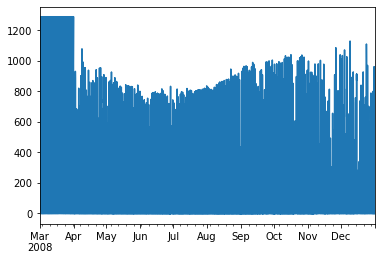

In [13]:
df_brb.loc[df_brb.index.year == 2008, 'global_rad'].plot()
plt.show()

Indeed, the values measured in the month of March look incorrect, let us replace them with the respective means, same way as before

In [14]:
# Creating time range for the period of interest
time_range = pd.date_range(start = '2008-03-01 00:00:00', end = '2008-03-31 23:00:00', freq = 'H')

# Creating final mask with the period where we know the outliers won't affect the final means, mask3 is no longer necessary
# since we've just dealt with it
mask = ~(mask1 & mask2), 'global_rad'

# Calculating means
correct_values = df_brb.loc[mask].groupby([df_brb.loc[mask].index.month, df_brb.loc[mask].index.day, df_brb.loc[mask].index.hour]).mean().unstack()

for date in time_range:
    # Saving the date
    m = 3
    d = date.day
    h = date.hour
    
    # Calculating the means with groupby
    correct_value = correct_values.loc[m,d][h]
    
    # Replacing values
    df_brb.loc[date, 'global_rad'] = correct_value

Let us check our final result for the global radiation after removing the outliers:

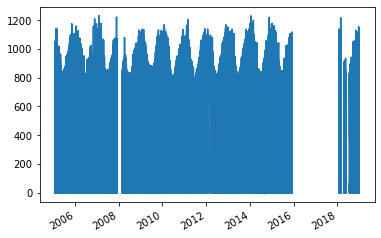

In [15]:
df_brb.global_rad.plot()
plt.show()

Now we have to deal with missing values, first, let us count how many we have.

In [16]:
print(df_brb.global_rad.isna().sum(), 'missing values')
print(round(df_brb.global_rad.isna().sum()/len(df_brb),3) * 100, '% of the total')

8518 missing values
8.3 % of the total


5.2% seems to be a good margin to work with, we can leave them as it is.

##### Temperature and precipitation

Cleaning this temperature and precipitation data seems to be a task not worth taking, perhaps we can use the data collected by a different weather station, in the same city.
Data from the Brazilian National Meteorology Institute (INMET) available at: https://bdmep.inmet.gov.br/ .

In [17]:
path = rf"C:\Users\rodri\Documents\Unifesp\Mestrado\Dados cidades"
os.chdir(path)

Before reading the file, open it with MS Excel and manually rename the columns as our previous pattern.

In [18]:
df2_brb = pd.read_csv('brb_inmet.csv', skiprows=10, sep=';', low_memory=False)

In [19]:
df2_brb.index = pd.date_range(start = '2005-01-01 00:00:00', end = '2020-12-31 23:00:00', freq = 'H')
df2_brb.drop(columns=['date','hour'], inplace=True)

In [20]:
df2_brb

,prec,global_rad,temp,temp_max,temp_min
2005-01-01 00:00:00,0.0,NaN,20.4,20.7,20.4
2005-01-01 01:00:00,0.0,NaN,19.9,20.6,19.9
2005-01-01 02:00:00,0.0,NaN,19.9,19.9,19.6
2005-01-01 03:00:00,0.0,NaN,19.6,20.0,19.6
2005-01-01 04:00:00,0.0,NaN,19.2,19.6,19.2
...,...,...,...,...,...
2020-12-31 19:00:00,0.0,"1005,042",28.1,29.3,28.0
2020-12-31 20:00:00,0.0,"312,961",23.6,28.1,23.5
2020-12-31 21:00:00,0.0,"292,168",23.6,23.6,22.6
2020-12-31 22:00:00,0.0,"123,22",22.3,23.6,22.3


It seems we have mixed types of data, where global_rad uses ',' as decimal point.

In [21]:
# Changing data type to string, replacing ',' with '.' and returning it as float
df2_brb.global_rad = df2_brb.global_rad.astype('string').str.replace(',','.').astype(float)

In [22]:
df2_brb.describe()

,prec,global_rad,temp,temp_max,temp_min
count,138815.000000,135470.000000,138917.000000,138900.000000,138900.000000
mean,0.164938,948.012897,21.435826,22.126118,20.775439
std,1.330859,2397.012968,3.728629,3.835951,3.617321
min,0.000000,-43.000000,8.700000,9.400000,8.500000
25%,0.000000,-3.540000,18.800000,19.300000,18.400000
50%,0.000000,27.408500,20.900000,21.600000,20.200000
75%,0.000000,1542.284500,24.100000,25.000000,23.300000
max,60.800000,43969.000000,35.500000,36.500000,34.400000


Our previous global_rad was measured as w/m², the unit in this Dataframe is kJ/m², a conversion is needed.

In [23]:
df2_brb.global_rad = (df2_brb.global_rad * 1000) / 3600 

Inspecting our new data for outliers:

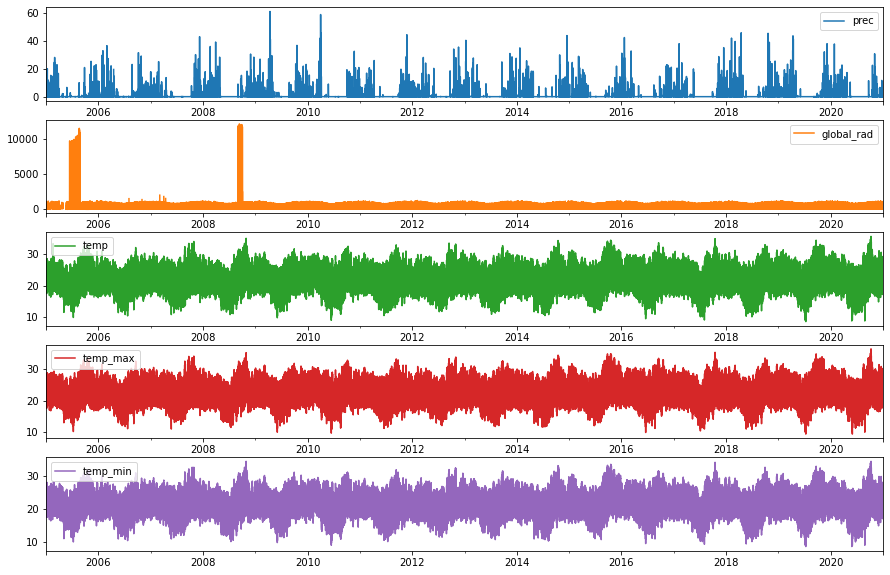

In [24]:
df2_brb.plot(subplots= True, figsize=(15, 10), sharex= False, sharey=False)
plt.show()

Global radiation data has some outliers in 2005 and 2008, but we can fix it.

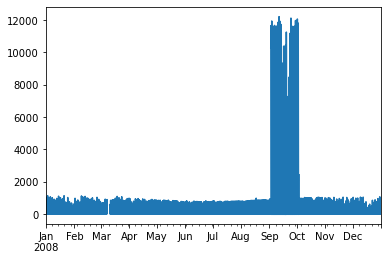

In [25]:
df2_brb.loc[df2_brb.index.year == 2008, 'global_rad'].plot()
plt.show()

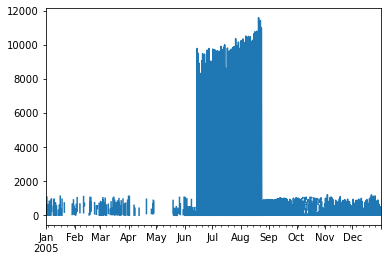

In [26]:
df2_brb.loc[df2_brb.index.year == 2005, 'global_rad'].plot()
plt.show()

In [27]:
# Getting every index where the global radiation values exceed the solar constant
outlier_index = df2_brb.global_rad[df2_brb.global_rad > 1327].index

# Creating mask with the period where we know the outliers won't affect the final means
mask = ~(df2_brb.index.isin(outlier_index)), 'global_rad'

# Calculating means
correct_values = df2_brb.loc[mask].groupby([df2_brb.loc[mask].index.month, df2_brb.loc[mask].index.day, df2_brb.loc[mask].index.hour]).mean().unstack()

for outlier_date in outlier_index:
    # Saving the date
    m = outlier_date.month
    d = outlier_date.day
    h = outlier_date.hour
    
    # Calculating the means with groupby
    correct_value = correct_values.loc[m,d][h]
    
    # Replacing values
    df2_brb.loc[outlier_date, 'global_rad'] = correct_value

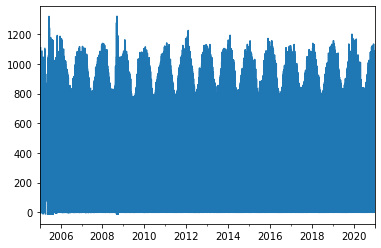

In [28]:
df2_brb.global_rad.plot()
plt.show()

This looks like an overall better dataset for this location, so from now on this will be our Dataframe for BRB.

#### Cachoeira Paulista (CPA)

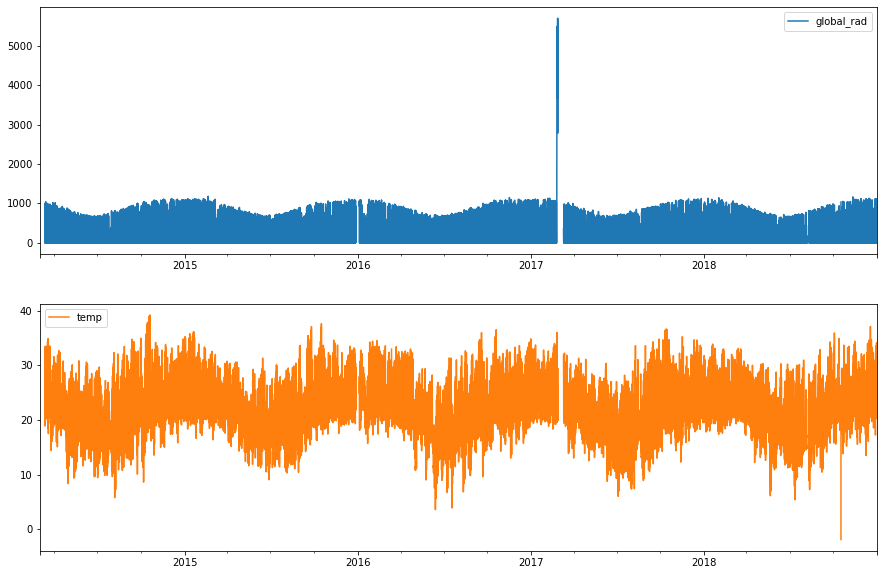

In [29]:
main_df[main_df.city == 'CPA'].plot(subplots= True, figsize=(15, 10), sharex= False, sharey=False)
plt.show()

There's no precipitation data for this location, but apart from that all we have to do is take care of some outliers in the global radiation values, one negative temperature value in 2018 that deserves some attention and we're good to go. For the precipitation data we can use a weather station located in the city of Taubaté, 75 km away from our site of interest.

##### Global radiation

In [30]:
df_cpa = main_df[main_df.city == 'CPA'].drop(columns=['city'])

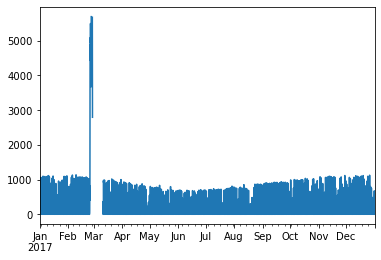

In [31]:
df_cpa.loc[df_cpa.index.year == 2017, 'global_rad'].plot()
plt.show()

In [32]:
# Getting the index of every outlier
outlier_index = df_cpa.global_rad[df_cpa.global_rad > 1327].index

# Creating mask with the period where we know the outliers won't affect the final means
mask = ~(df_cpa.index.isin(outlier_index)), 'global_rad'

# Calculating means
correct_values = df_cpa.loc[mask].groupby([df_cpa.loc[mask].index.month, df_cpa.loc[mask].index.day, df_cpa.loc[mask].index.hour]).mean().unstack()

for outlier_date in outlier_index:
    # Saving the date
    m = outlier_date.month
    d = outlier_date.day
    h = outlier_date.hour
    
    # Calculating the means with groupby
    correct_value = correct_values.loc[m,d][h]
    
    # Replacing values
    df_cpa.loc[outlier_date, 'global_rad'] = correct_value

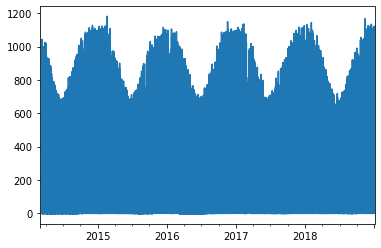

In [33]:
df_cpa.global_rad.plot()
plt.show()

##### Temperature

In [34]:
df_cpa.temp[df_cpa.temp < 0]

2018-10-17 13:00:00   -1.881613
Name: temp, dtype: float64

A negative temperature in this city is highly unlikely given it's geographical location, specially during spring, this value must be an error.

In [35]:
outlier_date = df_cpa.temp[df_cpa.temp < 0].index

# Saving the date
m = outlier_date.month[0]
d = outlier_date.day[0]
h = outlier_date.hour[0]

# Calculating the means with groupby
correct_value = df_cpa.temp.groupby([df_cpa.index.month, df_cpa.index.day, df_cpa.index.hour]).mean().unstack().loc[m,d][h]

# Replacing values
df_cpa.loc[outlier_date, 'temp'] = correct_value

##### Precipitation

The same approach when we first used data from INMET will be used here

In [36]:
df2_cpa = pd.read_csv('cpa_inmet.csv', skiprows=10, sep=';', low_memory=False)

In [37]:
df2_cpa

,date,hour,prec
0,01/01/2007,0,"0,8"
1,01/01/2007,100,"0,8"
2,01/01/2007,200,"0,6"
3,01/01/2007,300,"1,6"
4,01/01/2007,400,"0,2"
...,...,...,...
122731,31/12/2020,1900,0
122732,31/12/2020,2000,0
122733,31/12/2020,2100,0
122734,31/12/2020,2200,0


In [38]:
df2_cpa.index = pd.date_range(start = '2007-01-01 00:00:00', end = '2020-12-31 23:00:00', freq = 'H')
df2_cpa.drop(columns=['date','hour'], inplace=True)

In [39]:
# Changing data type to string, replacing ',' with '.' and returning it as float
df2_cpa.prec = df2_cpa.prec.astype('string').str.replace(',','.').astype(float)

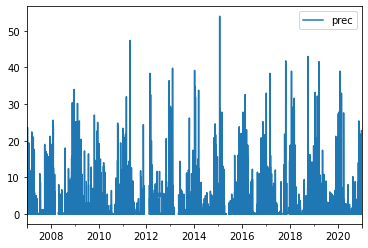

In [40]:
df2_cpa.plot()
plt.show()

#### Petrolina (PTR)

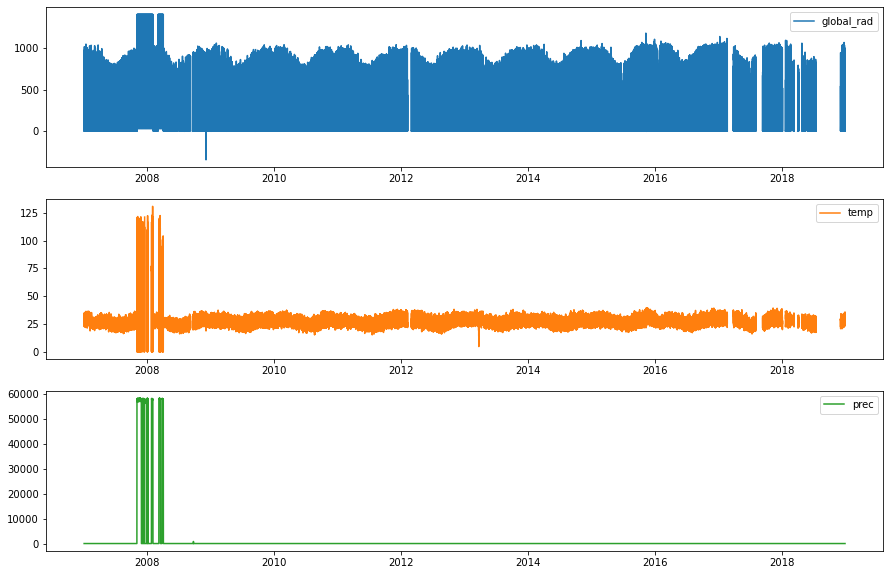

In [41]:
main_df[main_df.city == 'PTR'].plot(subplots= True, figsize=(15, 10), sharex= False, sharey=False)
plt.show()

It appears to be something wrong with the data concerning the period between 2007-2008, the precipitation data is non-existent. First, let us take care of the global radiation

##### Global radiation

In [42]:
df_ptr = main_df[main_df.city == 'PTR'].drop(columns=['city'])

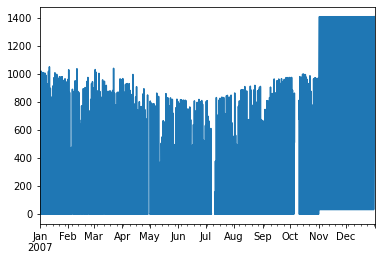

In [43]:
df_ptr.loc[df_ptr.index.year == 2007, 'global_rad'].plot()
plt.show()

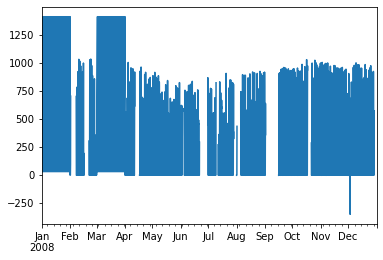

In [44]:
df_ptr.loc[df_ptr.index.year == 2008, 'global_rad'].plot()
plt.show()

From November 2007 to April 2008 the global radiation measurements are incorrect, in order to estimate values closer to reality, we can calculate the hourly means for the rest of the period and replace the faulty values.

In [45]:
# Creating time range
time_range = pd.date_range(start = '2007-11-01 00:00:00', end = '2008-04-30 23:00:00', freq = 'H')

# Creating mask with our period where we know the outliers won't affect the calculations
mask = df_ptr.index.year > 2008, 'global_rad'

# Calculating means
correct_values = df_ptr.loc[mask].groupby([df_ptr.loc[mask].index.month, df_ptr.loc[mask].index.day, df_ptr.loc[mask].index.hour]).mean().unstack()

for outlier_date in time_range:
    # Saving the date
    m = outlier_date.month
    d = outlier_date.day
    h = outlier_date.hour
    
    # Setting the correct values
    correct_value = correct_values.loc[m,d][h]
    
    # Replacing values
    df_ptr.loc[outlier_date, 'global_rad'] = correct_value

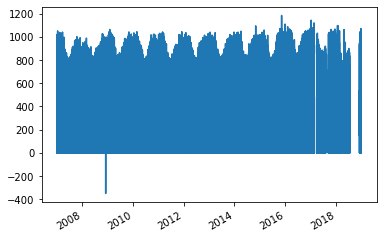

In [46]:
df_ptr.global_rad.plot()
plt.show()

There is still a single point with a value of almost -400, which is most likely incorrect, let us take a closer look

In [47]:
df_ptr.global_rad.nsmallest(5)

2008-12-03 04:00:00   -350.360450
2012-03-06 22:00:00     -4.479450
2009-09-14 22:00:00     -4.199183
2009-10-10 21:00:00     -4.121617
2008-12-01 01:00:00     -4.097167
Name: global_rad, dtype: float64

There he is (-350.360450), since its a value that took place during the evening, it is irrelevant to what we're doing, so we can either ignore him or set him equal to zero and carry on.

In [48]:
df_ptr.loc[df_ptr.global_rad < -300, 'global_rad'] = 0

##### Temperature

For the temperature and precipitarion, we can use the data provided by INMET for the same location.

In [49]:
df2_ptr = pd.read_csv('ptr_inmet.csv', skiprows=10, sep=';', low_memory=False)

In [50]:
df2_ptr

,date,hour,prec,global_rad,temp,temp_max,temp_min
0,01/01/2005,0,0,NaN,"29,1","29,7","29,1"
1,01/01/2005,100,0,NaN,"28,5","29,1","28,5"
2,01/01/2005,200,0,NaN,"28,2","28,5","28,2"
3,01/01/2005,300,0,NaN,"27,7","28,3","27,6"
4,01/01/2005,400,0,NaN,"27,7","28,2","27,6"
...,...,...,...,...,...,...,...
140251,31/12/2020,1900,0,"992,27","31,8","32,1","31,4"
140252,31/12/2020,2000,0,"529,709","31,5",32,"31,4"
140253,31/12/2020,2100,0,"333,906","31,7",32,"31,3"
140254,31/12/2020,2200,0,"42,52","30,5","31,7","30,5"


In [51]:
# Setting datetime range as index and dropping columns
df2_ptr.index = pd.date_range(start = '2005-01-01 00:00:00', end = '2020-12-31 23:00:00', freq = 'H')
df2_ptr.drop(columns=['date','hour', 'global_rad'], inplace=True)

In [52]:
# Changing data type to string, replacing ',' with '.' and returning it as float
df2_ptr.prec = df2_ptr.prec.astype('string').str.replace(',','.').astype(float)
df2_ptr.temp = df2_ptr.temp.astype('string').str.replace(',','.').astype(float)
df2_ptr.temp_max = df2_ptr.temp_max.astype('string').str.replace(',','.').astype(float)
df2_ptr.temp_min = df2_ptr.temp_min.astype('string').str.replace(',','.').astype(float)

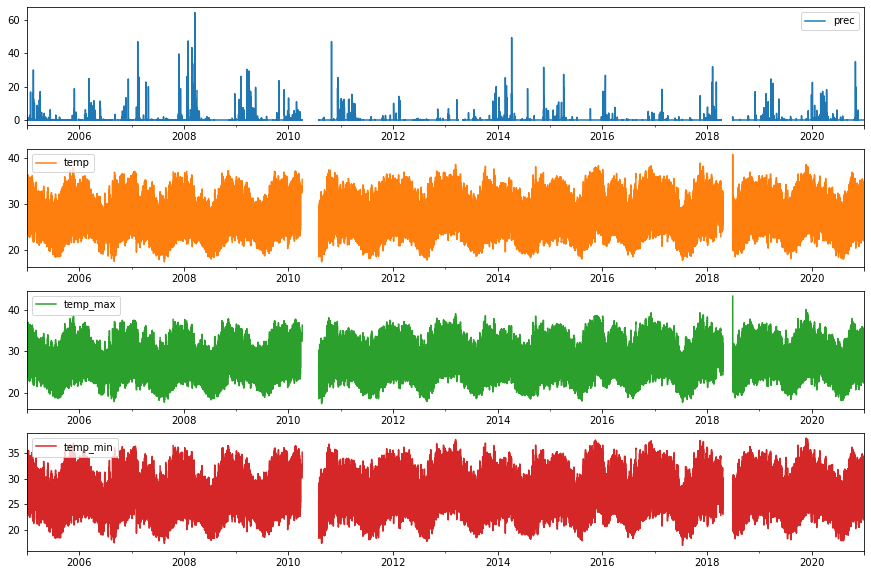

In [53]:
df2_ptr.plot(subplots= True, figsize=(15, 10), sharex= False, sharey=False)
plt.show()

There are some missing data, but considering the lenght of our observed period, it won't significantly affect the end result.

#### São Martinho da Serra (SMS)

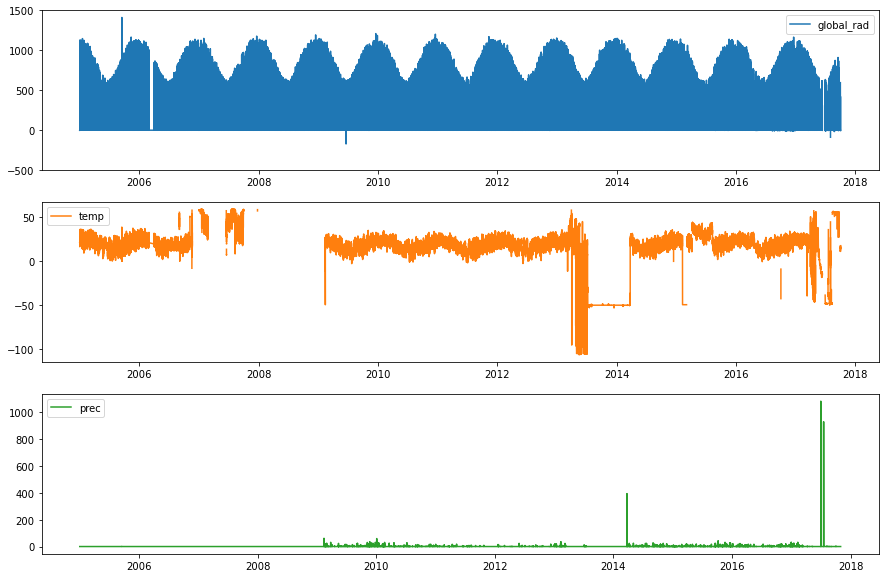

In [54]:
main_df[main_df.city == 'SMS'].plot(subplots= True, figsize=(15, 10), sharex= False, sharey=False)
plt.show()

Apart from a few outliers, global radiation data seems fine, but we must seek another source of surface data for temperature and precipitation.

In [55]:
df_sms = main_df[main_df.city == 'SMS'].drop(columns=['city'])

In [56]:
# Creating final mask with the period where we know the outliers won't affect the final means
mask = ~ df_sms.index.isin(outlier_index), 'global_rad'

# Getting every index where the global radiation values exceed the solar constant
outlier_index = df_sms.global_rad[df_sms.global_rad > 1200].index

# Calculating means
correct_values = df_sms.loc[mask].groupby([df_sms.loc[mask].index.month, df_sms.loc[mask].index.day, df_sms.loc[mask].index.hour]).mean().unstack()

for outlier_date in outlier_index:
    # Saving the date
    m = outlier_date.month
    d = outlier_date.day
    h = outlier_date.hour
    
    # Calculating the means with groupby
    correct_value = correct_values.loc[m,d][h]
    
    # Replacing values
    df_sms.loc[outlier_date, 'global_rad'] = correct_value

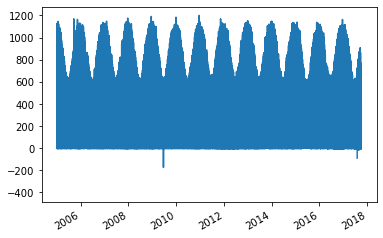

In [57]:
df_sms.global_rad.plot()
plt.show()

In [58]:
df_sms.global_rad.nsmallest(10)

2017-08-03 03:00:00   -410.100000
2009-06-19 19:00:00   -174.165000
2017-08-03 06:00:00    -90.000000
2017-08-26 23:00:00    -19.043344
2017-08-27 05:00:00     -9.598143
2017-07-01 21:00:00     -8.289717
2017-07-01 22:00:00     -8.270600
2016-12-05 04:00:00     -8.197533
2017-07-01 23:00:00     -8.049167
2017-07-02 00:00:00     -7.687117
Name: global_rad, dtype: float64

In [59]:
df_sms.loc[df_sms.global_rad < -10, 'global_rad'] = 0

For the temperature and precipitation data, we will once again download data from INMET, but there are no weather stations in São Martinho da Serra, our best option is the city of Ibirubá, which is 172 km away, but unlike other stations in our location's vicinity, has the same elevation (~460 m).

In [60]:
df2_sms = pd.read_csv('sms_inmet.csv', skiprows=10, sep=';', low_memory=False)

In [61]:
df2_sms

,date,hour,prec,temp,temp_max,temp_min
0,01/01/2013,0,0,"25,8","26,2","25,7"
1,01/01/2013,100,0,"25,5",26,"25,5"
2,01/01/2013,200,0,"25,5","25,6","25,3"
3,01/01/2013,300,0,"25,3","25,5","25,2"
4,01/01/2013,400,"8,8","17,9","25,3","17,9"
...,...,...,...,...,...,...
70123,31/12/2020,1900,0,27,"27,3","25,4"
70124,31/12/2020,2000,0,"26,2","27,1","25,8"
70125,31/12/2020,2100,0,"26,1","26,7",26
70126,31/12/2020,2200,0,"24,3","26,1","24,3"


In [62]:
# Setting datetime range as index and dropping columns
df2_sms.index = pd.date_range(start = '2013-01-01 00:00:00', end = '2020-12-31 23:00:00', freq = 'H')
df2_sms.drop(columns=['date','hour'], inplace=True)

In [63]:
# Changing data type to string, replacing ',' with '.' and returning it as float
df2_sms.prec = df2_sms.prec.astype('string').str.replace(',','.').astype(float)
df2_sms.temp = df2_sms.temp.astype('string').str.replace(',','.').astype(float)
df2_sms.temp_max = df2_sms.temp_max.astype('string').str.replace(',','.').astype(float)
df2_sms.temp_min = df2_sms.temp_min.astype('string').str.replace(',','.').astype(float)

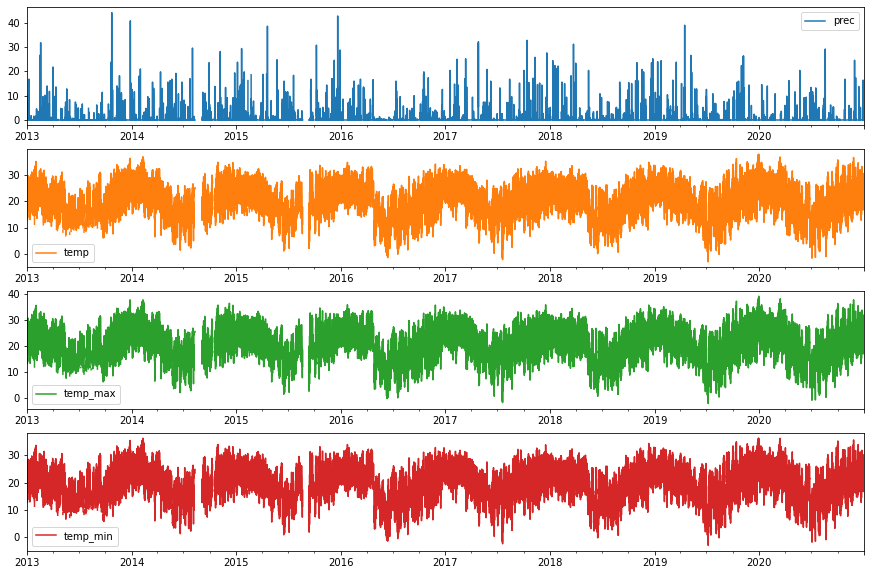

In [64]:
df2_sms.plot(subplots= True, figsize=(15, 10), sharex= False, sharey=False)
plt.show()

Everything looks in order, we can then proceed to plot the data.

### Visualizing the data

#### Temperature

First we will obtain the mean temperature, followed by the min and max, for each location

In [65]:
# Means for Brasilia
mean_brb = list(df2_brb.temp.groupby([df2_brb.index.month, df2_brb.index.day]).mean().reset_index().temp)
min_brb = list(df2_brb.temp.groupby([df2_brb.index.month, df2_brb.index.day]).min().reset_index().temp)
max_brb = list(df2_brb.temp.groupby([df2_brb.index.month, df2_brb.index.day]).max().reset_index().temp)

# Means for Cachoeira Paulista
mean_cpa = list(df_cpa.temp.groupby([df_cpa.index.month, df_cpa.index.day]).mean().reset_index().temp)
min_cpa = list(df_cpa.temp.groupby([df_cpa.index.month, df_cpa.index.day]).min().reset_index().temp)
max_cpa = list(df_cpa.temp.groupby([df_cpa.index.month, df_cpa.index.day]).max().reset_index().temp)

# Means for Petrolina
mean_ptr = list(df2_ptr.temp.groupby([df2_ptr.index.month, df2_ptr.index.day]).mean().reset_index().temp)
min_ptr = list(df2_ptr.temp.groupby([df2_ptr.index.month, df2_ptr.index.day]).min().reset_index().temp)
max_ptr = list(df2_ptr.temp.groupby([df2_ptr.index.month, df2_ptr.index.day]).max().reset_index().temp)

# Means for São Martinho da Serra
mean_sms = list(df2_sms.temp.groupby([df2_sms.index.month, df2_sms.index.day]).mean().reset_index().temp)
min_sms = list(df2_sms.temp.groupby([df2_sms.index.month, df2_sms.index.day]).min().reset_index().temp)
max_sms = list(df2_sms.temp.groupby([df2_sms.index.month, df2_sms.index.day]).max().reset_index().temp)

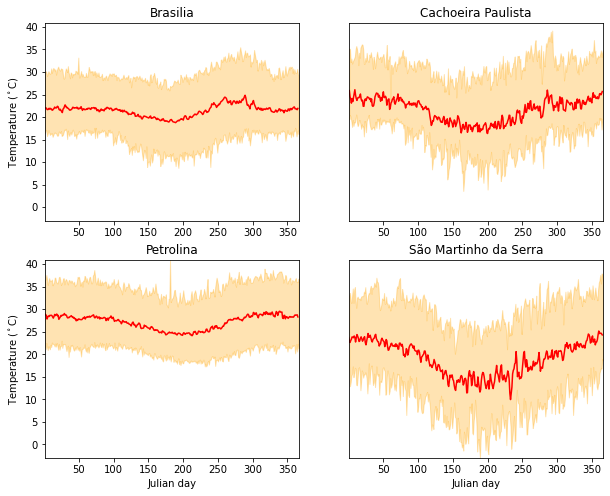

In [66]:
# Setting plot size
fig = plt.figure(figsize=(10,8))

# Brasília
ax1 = fig.add_subplot(2,2,1)
ax1.fill_between(np.arange(1,367,1), min_brb, max_brb,color='orange',alpha=0.3)
plt.plot(mean_brb, 'r',)
plt.xlim(1,366)
plt.ylim(min(min_sms), max(max_ptr))
plt.ylabel('Temperature ($^\circ$C)')
plt.title('Brasilia')

# Cachoeira Paulista
ax2 = fig.add_subplot(2,2,2)
ax2.fill_between(np.arange(1,367,1), min_cpa, max_cpa,color='orange',alpha=0.3)
plt.plot(mean_cpa, 'r',)
plt.xlim(1,366)
plt.ylim(min(min_sms), max(max_ptr))
ax = plt.gca()
ax.axes.yaxis.set_visible(False)
plt.title('Cachoeira Paulista')

# Petrolina
ax3 = fig.add_subplot(2,2,3)
ax3.fill_between(np.arange(1,367,1), min_ptr, max_ptr,color='orange',alpha=0.3)
plt.plot(mean_ptr, 'r',)
plt.xlim(1,366)
plt.ylim(min(min_sms), max(max_ptr))
plt.ylabel('Temperature ($^\circ$C)')
plt.xlabel('Julian day')
plt.title('Petrolina')

# São Martinho da Serra
ax4 = fig.add_subplot(2,2,4)
ax4.fill_between(np.arange(1,367,1), min_sms, max_sms,color='orange',alpha=0.3)
plt.plot(mean_sms, 'r',)
plt.xlim(1,366)
plt.ylim(min(min_sms), max(max_ptr))
ax = plt.gca()
ax.axes.yaxis.set_visible(False)
plt.xlabel('Julian day')
plt.title('São Martinho da Serra')
plt.show()

#### Precipitation

Calculating total rainfall per month for each location

In [67]:
# Means for monthly rainfall
# Brasilia
prec_brb = list(df2_brb.prec.groupby([df2_brb.index.month]).sum() / len(df2_brb.index.year.unique()))

# Cachoeira Paulista
prec_cpa = list(df2_cpa.prec.groupby([df2_cpa.index.month]).sum() / len(df2_cpa.index.year.unique()))

# Petrolina
prec_ptr = list(df2_ptr.prec.groupby([df2_ptr.index.month]).sum() / len(df2_ptr.index.year.unique()))

# São Martinho da Serra
prec_sms = list(df2_sms.prec.groupby([df2_sms.index.month]).sum() / len(df2_sms.index.year.unique()))

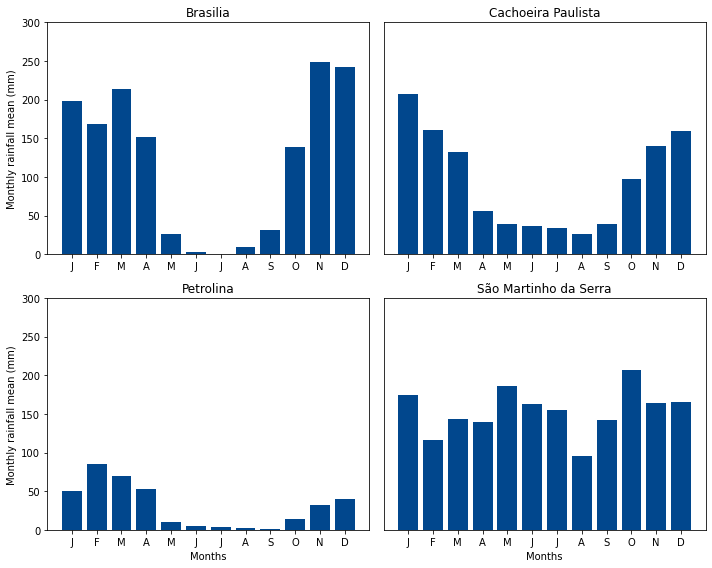

In [68]:
# Setting month labels
months = ['J','F','M','A','M','J','J','A','S','O','N','D']

# Setting plot size
fig = plt.figure(figsize=(10,8))

# Brasília
ax1 = fig.add_subplot(2,2,1)
ax1 = plt.bar(np.arange(1,13,1), prec_brb, color='#01478d')
plt.xticks(np.arange(1,13,1), labels = months)
plt.ylabel('Monthly rainfall mean (mm)')
plt.ylim([0,300])
plt.title('Brasilia')

# Cachoeira Paulista
ax2 = fig.add_subplot(2,2,2)
ax2 = plt.bar(np.arange(1,13,1), prec_cpa, color='#01478d')
plt.xticks(np.arange(1,13,1), labels = months)
plt.ylim([0,300])
ax = plt.gca()
ax.axes.yaxis.set_visible(False)
plt.title('Cachoeira Paulista')

# Petrolina
ax3 = fig.add_subplot(2,2,3)
ax3 = plt.bar(np.arange(1,13,1), prec_ptr, color='#01478d')
plt.xticks(np.arange(1,13,1), labels = months)
plt.xlabel('Months')
plt.ylabel('Monthly rainfall mean (mm)')
plt.ylim([0,300])
plt.title('Petrolina')

# São Martinho da Serra
ax4 = fig.add_subplot(2,2,4)
ax4 = plt.bar(np.arange(1,13,1), prec_sms, color='#01478d')
plt.xticks(np.arange(1,13,1), labels = months)
plt.xlabel('Months')
plt.ylim([0,300])
ax = plt.gca()
ax.axes.yaxis.set_visible(False)
plt.title('São Martinho da Serra')
plt.tight_layout()
plt.show()

#### Global radiation

In order to plot a heatmap of the global radiation we must first specify a period that excludes nighttime,
since our dataset uses the UTC time, we must take that into account when selecting our period.
Brazil is located in the timezone UTC -3, but after using the .resample function we already took 1 hour into account, so we must keep this in mind.

In [69]:
# Brasilia
# Selecting the period between 6:00 and 19:00 should ensure we get the full day cycle during every season.
rad_brb = df_brb.loc[df_brb.index.hour.isin([i for i in range(8,22)]), 'global_rad']

# Neglecting negative values
rad_brb.loc[rad_brb < 0] = 0

# Calculating the hourly mean of each month
rad_brb = rad_brb.groupby([rad_brb.index.month, rad_brb.index.hour]).mean()

# Turning the data into an array with shape (12,14), since a year has 12 months and we selected a 14 hour period
rad_brb = np.array(rad_brb.reset_index().global_rad).reshape(12,len([i for i in range(8,22)]))


# Cachoeira Paulista
# Selecting the period between 6:00 and 19:00 should ensure we get the full day cycle during every season.
rad_cpa = df_cpa.loc[df_cpa.index.hour.isin([i for i in range(8,22)]), 'global_rad']

# Neglecting negative values
rad_cpa.loc[rad_cpa < 0] = 0

# Calculating the hourly mean of each month
rad_cpa = rad_cpa.groupby([rad_cpa.index.month, rad_cpa.index.hour]).mean()

# Turning the data into an array with shape (12,14), since a year has 12 months and we selected a 14 hour period
rad_cpa = np.array(rad_cpa.reset_index().global_rad).reshape(12,len([i for i in range(8,22)]))


# Petrolina
# Selecting the period between 6:00 and 19:00 should ensure we get the full day cycle during every season.
rad_ptr = df_ptr.loc[df_ptr.index.hour.isin([i for i in range(8,22)]), 'global_rad']

# Neglecting negative values
rad_ptr.loc[rad_ptr < 0] = 0

# Calculating the hourly mean of each month
rad_ptr = rad_ptr.groupby([rad_ptr.index.month, rad_ptr.index.hour]).mean()

# Turning the data into an array with shape (12,14), since a year has 12 months and we selected a 14 hour period
rad_ptr = np.array(rad_ptr.reset_index().global_rad).reshape(12,len([i for i in range(8,22)]))


# São Martinho da Serra
# Selecting the period between 6:00 and 19:00 should ensure we get the full day cycle during every season.
rad_sms = df_sms.loc[df_sms.index.hour.isin([i for i in range(8,22)]), 'global_rad']

# Neglecting negative values
rad_sms.loc[rad_sms < 0] = 0

# Calculating the hourly mean of each month
rad_sms = rad_sms.groupby([rad_sms.index.month, rad_sms.index.hour]).mean()

# Turning the data into an array with shape (12,14), since a year has 12 months and we selected a 14 hour period
rad_sms = np.array(rad_sms.reset_index().global_rad).reshape(12,len([i for i in range(8,22)]))

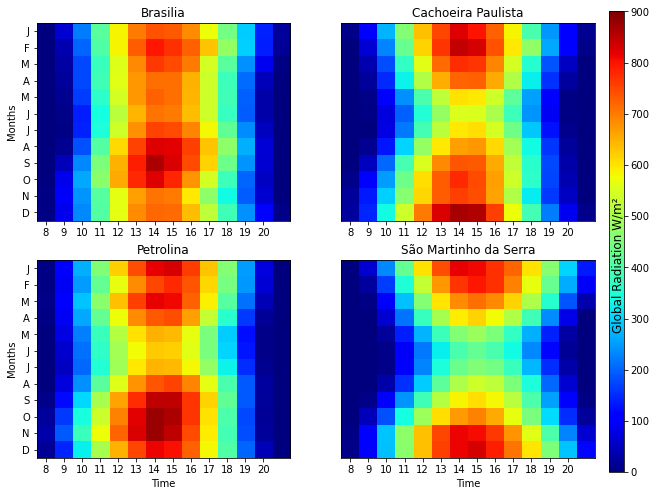

In [70]:
# Setting plot size
fig = plt.figure(figsize=(10,8))

# Brasília
ax1 = fig.add_subplot(2,2,1)
ax1 = plt.imshow(rad_brb, vmin=0, vmax=900, cmap='jet', aspect='auto')
plt.yticks(np.arange(0,12,1), labels = months)
plt.ylabel('Months')
plt.xticks(np.arange(0,13,1), labels = np.arange(8,21,1))
plt.title('Brasilia')

# Cachoeira Paulista
ax2 = fig.add_subplot(2,2,2)
ax2 = plt.imshow(rad_cpa, vmin=0, vmax=900, cmap='jet', aspect='auto')
plt.yticks(np.arange(0,12,1), labels = months)
ax = plt.gca()
ax.axes.yaxis.set_visible(False)
plt.xticks(np.arange(0,13,1), labels = np.arange(8,21,1))
plt.title('Cachoeira Paulista')

# Petrolina
ax3 = fig.add_subplot(2,2,3)
ax3 = plt.imshow(rad_ptr, vmin=0, vmax=900, cmap='jet', aspect='auto')
plt.yticks(np.arange(0,12,1), labels = months)
plt.ylabel('Months')
plt.xticks(np.arange(0,13,1), labels = np.arange(8,21,1))
plt.xlabel('Time')
plt.title('Petrolina')

# São Martinho da Serra
ax4 = fig.add_subplot(2,2,4)
ax4 = plt.imshow(rad_sms, vmin=0, vmax=900, cmap='jet', aspect='auto')
plt.yticks(np.arange(0,12,1), labels = months)
ax = plt.gca()
ax.axes.yaxis.set_visible(False)
plt.xticks(np.arange(0,13,1), labels = np.arange(8,21,1))
plt.xlabel('Time')
plt.title('São Martinho da Serra')

# Setting colorbar 
cb_ax = fig.add_axes([0.92, 0.1, 0.02, 0.8])
cbar = fig.colorbar(ax4, cax=cb_ax)
cbar.set_ticks(np.arange(0, 901, 100))
cbar.set_label('Global Radiation W/m²', fontsize = 12, labelpad=-38, y=0.45)
plt.show()